# Asteroid Class Prediction Leveraging Parallelization Techniques 

<div style="text-align: right">  
<strong>Uday Kiran Dasari</strong>
</div>
<br/>
<center>
<img src="Asteroid.jpg" width=700 />
</center>
<br/>

**Link to Dataset used**: [**Asteroid Dataset**](https://www.kaggle.com/datasets/sakhawat18/asteroid-dataset/data)

### Dataset Description

- **SPK-ID:** Object primary SPK-ID
- **Object ID:** Object internal database ID
- **Object fullname:** Object full name/designation
- **pdes:** Object primary designation
- **name:** Object IAU name
- **NEO:** Near-Earth Object (NEO) flag
- **PHA:** Potentially Hazardous Asteroid (PHA) flag
- **H:** Absolute magnitude parameter
- **Diameter:** Object diameter (from equivalent sphere) km Unit
- **Albedo:** Geometric albedo
- **Diameter_sigma:** 1-sigma uncertainty in object diameter km Unit
- **Orbit_id:** Orbit solution ID
- **Epoch:** Epoch of osculation in modified Julian day form
- **Equinox:** Equinox of reference frame
- **e:** Eccentricity
- **a:** Semi-major axis au Unit
- **q:** Perihelion distance au Unit
- **i:** Inclination; angle with respect to x-y ecliptic plane
- **tp:** Time of perihelion passage TDB Unit
- **moid_ld:** Earth Minimum Orbit Intersection Distance au Unit
-y ecliptic plane

### Necessary Libraries

In [1]:
# Basic imports
import joblib
import numpy as np
import pandas as pd
import time
import multiprocessing
from tqdm import tqdm

# Visualization imports
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# Dask-related imports
import dask
import dask.array as da
import dask.dataframe as dd
from dask_ml.impute import SimpleImputer
from dask.distributed import Client, config
from dask.diagnostics import ProgressBar
from dask_ml.model_selection import GridSearchCV,train_test_split

# Set the daemon configuration for Dask workers
dask.config.set({'distributed.worker.daemon': False})

import warnings
warnings.filterwarnings('ignore', category=UserWarning)
# Torch Related Imports
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
# Inline matplotlib setup
%matplotlib inline

### Data Preprocessing

#### Loading the dataset

In [2]:
# Load the dataset with specified data types
#data = dd.read_csv('./dataset.csv', dtype=dtype)
astro_ds = dd.read_csv('./dataset.csv')
# Check data types and info
print(astro_ds.dtypes)
astro_ds.head()

id                string[pyarrow]
spkid                       int64
full_name         string[pyarrow]
pdes                        int64
name              string[pyarrow]
prefix                    float64
neo               string[pyarrow]
pha               string[pyarrow]
H                         float64
diameter                  float64
albedo                    float64
diameter_sigma            float64
orbit_id          string[pyarrow]
epoch                     float64
epoch_mjd                   int64
epoch_cal                 float64
equinox           string[pyarrow]
e                         float64
a                         float64
q                         float64
i                         float64
om                        float64
w                         float64
ma                        float64
ad                        float64
n                         float64
tp                        float64
tp_cal                    float64
per                       float64
per_y         

,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,a0000001,2000001,1 Ceres,1,Ceres,NaN,N,N,3.40,939.400,...,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,a0000002,2000002,2 Pallas,2,Pallas,NaN,N,N,4.20,545.000,...,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,a0000003,2000003,3 Juno,3,Juno,NaN,N,N,5.33,246.596,...,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,a0000004,2000004,4 Vesta,4,Vesta,NaN,N,N,3.00,525.400,...,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,a0000005,2000005,5 Astraea,5,Astraea,NaN,N,N,6.90,106.699,...,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191


In [3]:
# Drop columns early in the process
columns_to_drop = ['id', 'full_name', 'pdes', 'name', 'prefix', 'neo', 'pha', 'orbit_id', 'equinox']
astro_ds = astro_ds.drop(columns_to_drop, axis=1)
astro_ds.head()

,spkid,H,diameter,albedo,diameter_sigma,epoch,epoch_mjd,epoch_cal,e,a,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,2000001,3.40,939.400,0.0900,0.200,2458600.5,58600,20190427.0,0.076009,2.769165,...,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,2000002,4.20,545.000,0.1010,18.000,2459000.5,59000,20200531.0,0.229972,2.773841,...,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,2000003,5.33,246.596,0.2140,10.594,2459000.5,59000,20200531.0,0.256936,2.668285,...,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,2000004,3.00,525.400,0.4228,0.200,2458600.5,58600,20190427.0,0.088721,2.361418,...,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,2000005,6.90,106.699,0.2740,3.140,2459000.5,59000,20200531.0,0.190913,2.574037,...,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191


In [4]:
astro_ds.describe().compute()

,spkid,H,diameter,albedo,diameter_sigma,epoch,epoch_mjd,epoch_cal,e,a,...,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,rms
count,9.585240e+05,952261.000000,136209.000000,135103.000000,136081.000000,9.585240e+05,958524.000000,9.585240e+05,958524.000000,958524.000000,...,9.386020e+05,9.386020e+05,9.386020e+05,9.386020e+05,9.386020e+05,9.385980e+05,9.386020e+05,9.386020e+05,9.385980e+05,958522.000000
mean,3.810114e+06,16.906411,5.506429,0.130627,0.479184,2.458869e+06,58868.781950,2.019693e+07,0.156116,2.902143,...,1.982929e+01,1.168449e+00,5.310234e+00,1.370062e+06,1.369977e+06,2.131453e+01,5.060221e-02,4.312780e+08,8.525815e+04,0.561153
std,6.831541e+06,1.790405,9.425164,0.110323,0.782895,7.016716e+02,701.671573,1.930354e+04,0.092643,39.719503,...,2.903785e+03,1.282231e+02,1.333381e+03,9.158996e+08,9.158991e+08,7.197034e+03,9.814953e+00,2.953046e+11,2.767681e+07,2.745700
min,2.000001e+06,-1.100000,0.002500,0.001000,0.000500,2.425052e+06,25051.000000,1.927062e+07,0.000000,-14702.447872,...,1.956900e-11,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,0.000000
25%,2.234853e+06,16.500000,3.174000,0.069000,0.257000,2.459000e+06,59000.000000,2.020053e+07,0.101109,2.419544,...,1.465500e-07,6.123925e-06,5.050300e-05,6.537500e-05,3.093900e-05,2.331700e-08,3.008025e-09,1.342400e-04,1.815800e-05,0.545030
50%,2.472890e+06,17.300000,4.649000,0.102000,0.487000,2.459000e+06,59000.000000,2.020053e+07,0.163274,2.675917,...,2.977450e-07,1.032100e-05,9.441200e-05,1.272275e-04,6.443200e-05,6.726850e-08,6.711900e-09,2.941000e-04,5.373900e-05,0.582160
75%,3.762552e+06,18.618000,6.201000,0.188000,0.812000,2.459000e+06,59000.000000,2.020053e+07,0.228230,3.041111,...,9.311900e-05,1.006100e-03,1.334400e-03,1.325300e-02,2.569900e-02,1.603500e-04,2.676450e-06,8.251200e-02,1.153200e-01,0.635050
max,5.401723e+07,33.200000,939.400000,1.000000,140.000000,2.459000e+06,59000.000000,2.020053e+07,1.855356,33488.895955,...,1.015000e+06,5.533000e+04,1.199100e+06,8.845100e+11,8.845100e+11,5.509700e+06,7.698800e+03,2.853100e+14,1.910700e+10,2686.600000


In [5]:
astro_ds.isnull().sum().compute()

spkid                  0
H                   6263
diameter          822315
albedo            823421
diameter_sigma    822443
epoch                  0
epoch_mjd              0
epoch_cal              0
e                      0
a                      0
q                      0
i                      0
om                     0
w                      0
ma                     1
ad                     4
n                      0
tp                     0
tp_cal                 0
per                    4
per_y                  1
moid               19921
moid_ld              127
sigma_e            19922
sigma_a            19922
sigma_q            19922
sigma_i            19922
sigma_om           19922
sigma_w            19922
sigma_ma           19922
sigma_ad           19926
sigma_n            19922
sigma_tp           19922
sigma_per          19926
class                  0
rms                    2
dtype: int64

#### Null Value Handling

In [6]:
# Prepare features for imputation (excluding the target 'class')
X = astro_ds.drop(['class'], axis=1)
y = astro_ds['class']

In [7]:
# Applying SimpleImputer from Dask-ML to handle missing values in parallel
imputer = SimpleImputer(strategy='median')

# Since Dask works with lazy evaluation, use compute() to perform the computation
X_imputed = imputer.fit_transform(X)

In [8]:
# Ensure that imputation and other transformations are computed efficiently
with ProgressBar():
    X_imputed = X_imputed.compute()  # This will trigger the actual computation
    y = y.compute()  # Ensure the target variable is also ready for model training

[########################################] | 100% Completed | 1.59 ss
[########################################] | 100% Completed | 1.12 ss


### Feature Importance


- Using the Extra Trees Classifier using `JOBLIB` and `MULTIPROCESSING` libraries

In [9]:
%%time
# Split data into training and test sets (consider doing this before imputation if you want a more rigorous evaluation)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2,shuffle =True ,random_state=42)

# Initialize the ExtraTreesClassifier
# Note: You can adjust n_estimators, max_depth, and other parameters as needed
etc = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# To leverage parallel computation with Dask when performing model fitting
with joblib.parallel_backend('multiprocessing'):
    # Fit the model
    etc.fit(X_train, y_train)

CPU times: user 2.69 s, sys: 2.78 s, total: 5.47 s
Wall time: 10.8 s


#### Visualizing the feature importances

Feature importances:
spkid: 0.00385
H: 0.04009
diameter: 0.00133
albedo: 0.00177
diameter_sigma: 0.00093
epoch: 0.00234
epoch_mjd: 0.00255
epoch_cal: 0.00275
e: 0.07411
a: 0.09232
q: 0.12400
i: 0.03087
om: 0.00209
w: 0.00265
ma: 0.00333
ad: 0.05627
n: 0.14841
tp: 0.00530
tp_cal: 0.00540
per: 0.09265
per_y: 0.08823
moid: 0.11557
moid_ld: 0.08445
sigma_e: 0.00127
sigma_a: 0.00125
sigma_q: 0.00154
sigma_i: 0.00162
sigma_om: 0.00159
sigma_w: 0.00154
sigma_ma: 0.00157
sigma_ad: 0.00129
sigma_n: 0.00109
sigma_tp: 0.00155
sigma_per: 0.00191
rms: 0.00254


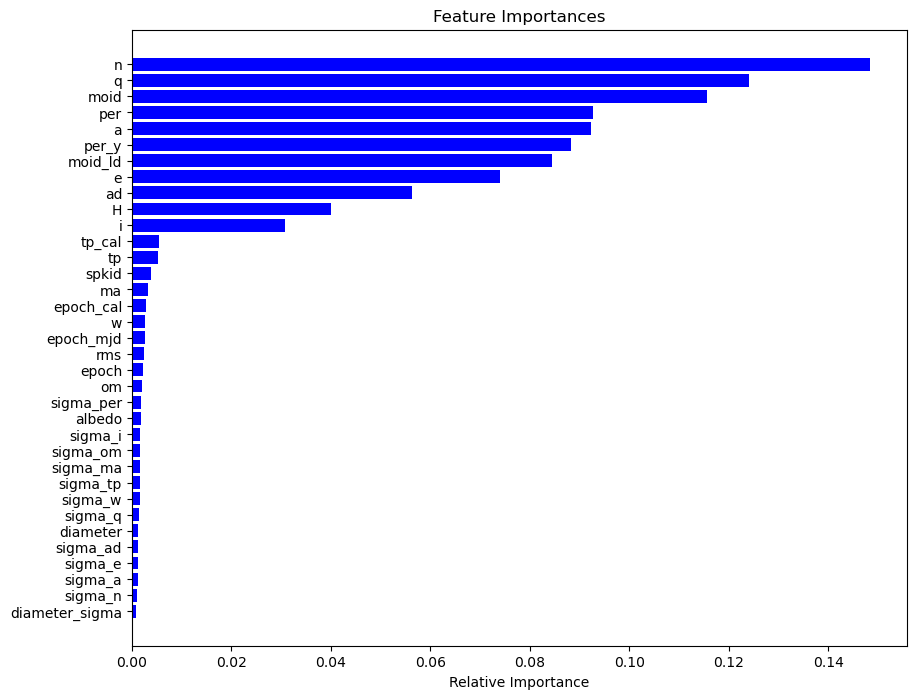

In [10]:
# Compute and print feature importances
feature_importances = etc.feature_importances_

# Create a dictionary to hold feature names and their importance values
features = X_train.columns
feature_importance_dict = dict(zip(features, feature_importances))

# Print feature importances along with their names
print("Feature importances:")
for feature, importance in feature_importance_dict.items():
    print(f"{feature}: {importance:.5f}")

# Visualize the feature importance
plt.figure(figsize=(10, 8))
indices = np.argsort(feature_importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Selection of Importance Features

In [11]:
threshold = np.mean(feature_importances)  # Define your threshold here

# Selecting features with importance greater than the threshold
selected_features = [feature for feature, importance in zip(X_train.columns, feature_importances) if importance > threshold]

print("Selected features:", selected_features)

Selected features: ['H', 'e', 'a', 'q', 'i', 'ad', 'n', 'per', 'per_y', 'moid', 'moid_ld']


In [12]:
# Include 'class' in selected features
selected_features.append('class')

# Filter the original Dask DataFrame to include only selected features
astro_ds_filtered = astro_ds[selected_features]

In [13]:
astro_ds_filtered.isnull().sum().compute()

H           6263
e              0
a              0
q              0
i              0
ad             4
n              0
per            4
per_y          1
moid       19921
moid_ld      127
class          0
dtype: int64

In [14]:
# Prepare features for imputation (excluding the target 'class')
X = astro_ds_filtered.drop(['class'], axis=1)
y = astro_ds_filtered['class']

In [15]:
# Applying SimpleImputer from Dask-ML to handle missing values in parallel
imputer = SimpleImputer(strategy='median')

# Since Dask works with lazy evaluation, use compute() to perform the computation
X_imputed = imputer.fit_transform(X)

In [16]:
# Ensure that imputation and other transformations are computed efficiently
with ProgressBar():
    X_imputed = X_imputed.compute()  # This will trigger the actual computation
    y = y.compute()  # Ensure the target variable is also ready for model training

[########################################] | 100% Completed | 1.07 sms
[########################################] | 100% Completed | 1.14 sms


In [17]:
X_imputed.isnull().sum()

H          0
e          0
a          0
q          0
i          0
ad         0
n          0
per        0
per_y      0
moid       0
moid_ld    0
dtype: int64

In [18]:
y.unique()

array(['MBA', 'OMB', 'MCA', 'AMO', 'IMB', 'TJN', 'CEN', 'APO', 'ATE',
       'AST', 'TNO', 'IEO', 'HYA'], dtype=object)

### Test Train Split

In [19]:
# Split the data into training and test sets
#from dask_ml.model_selection import GridSearchCV,train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2,shuffle=True, random_state=42)

In [20]:
type(X_train),type(X_test),type(y_train),type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series)

#### Scaling and Encoding

In [21]:
# Scaling the data using Dask-ML's StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

In [23]:
type(X_train_scaled),type(X_test_scaled),type(y_train_encoded),type(y_test_encoded)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [24]:
X_train_scaled.shape,X_test_scaled.shape,y_train_encoded.shape,y_test_encoded.shape

((766819, 11), (191705, 11), (766819,), (191705,))

In [25]:
# If these are pandas DataFrame, convert them to Dask DataFrame
#X_train, y_train, X_test, y_test = dd.from_pandas(X_train), dd.from_pandas(y_train), dd.from_pandas(X_test), dd.from_pandas(y_test)

In [26]:
X_train.shape

(766819, 11)

## Neural Network using Pytorch

### Data Parallel

#### Data Preparation for NN

In [27]:
# Convert arrays to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train_encoded)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test_encoded)

# Load data into DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

#### NN Model Architecture

In [28]:
# Define the neural network architecture
class RobustNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RobustNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.layer2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)
        self.layer3 = nn.Linear(hidden_size // 2, num_classes)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return x

#### Check if multiple GPUs are available and wrap the model using nn.DataParallel

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RobustNN(input_size=X_train.shape[1], hidden_size=100, num_classes=13)
if torch.cuda.device_count() > 1:
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    # This will split data across the GPUs
    model = nn.DataParallel(model)

model.to(device)

RobustNN(
  (layer1): Linear(in_features=11, out_features=100, bias=True)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer2): Linear(in_features=100, out_features=50, bias=True)
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=50, out_features=13, bias=True)
)

#### Initialize the loss criterion and optimizer

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Model Training

In [31]:
# Initialize lists to store per-epoch metrics
train_losses = []
val_losses = []
val_accuracies = []
# Train the model
start_time = time.time()
num_epochs = 5
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    val_losses.append(val_loss / len(test_loader.dataset))
    val_accuracies.append(correct / total)
end_time = time.time()
# Time taken
time_taken_nn = end_time - start_time
print(f"Time taken for training: {time_taken_nn:.2f} seconds")

100%|██████████| 5/5 [03:00<00:00, 36.13s/it]

Time taken for training: 180.68 seconds


#### Model Evaluation visualization

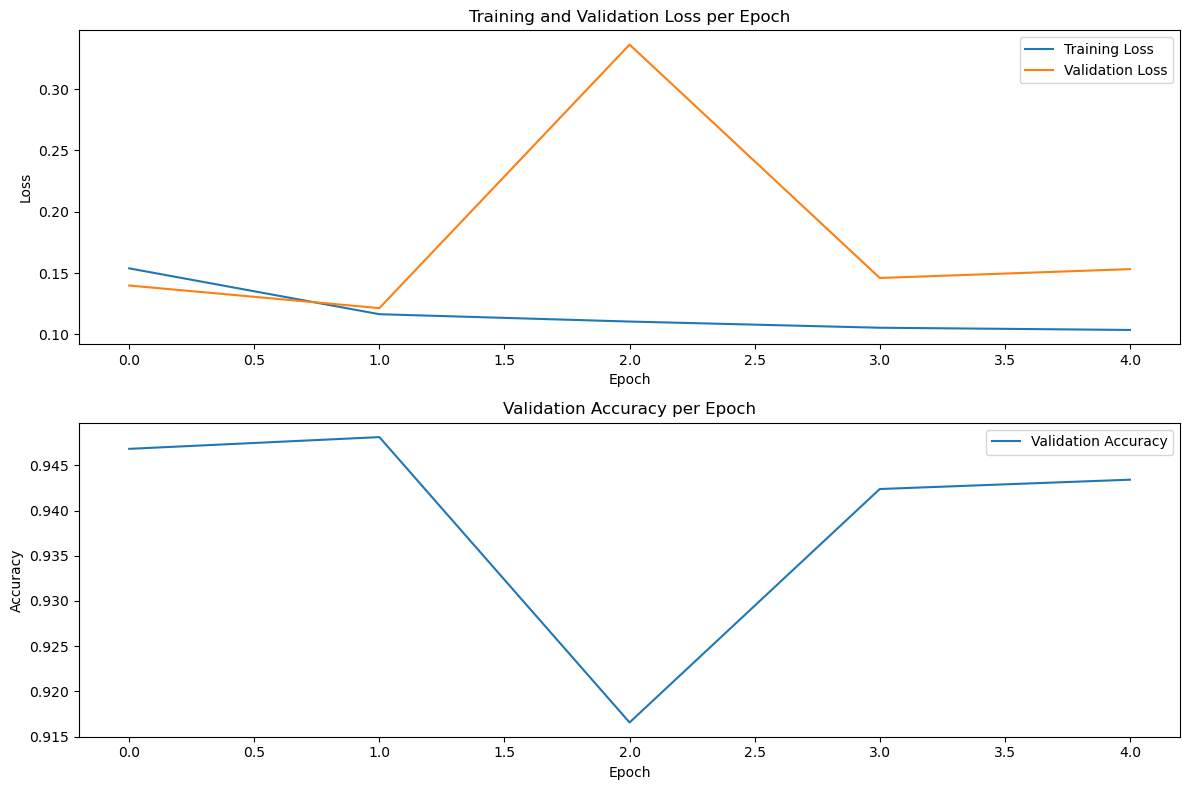

In [32]:
plt.figure(figsize=(12, 8))

# Training and Validation Loss
plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy
plt.subplot(2, 1, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()